# 5. Simple image filtering

In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import IPython.display
%matplotlib widget
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.simple_image_filtering import halfcos, convse

In [2]:
# load the image as we did before
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})

An effective image lowpass filter, of odd length $N$, may be obtained by defining the impulse
response $h(n)$ to be a sampled half-cosine pulse:

$$h(n) = G \cos \left(\frac{n\pi}{N + 1}\right),\qquad \text{for} \qquad \frac{-(N - 1)}{2} \le n \le \frac{N - 1}{2}$$

where $G$ is a gain factor, which, in order to give unity gain at zero frequency, should be calculated such that

$$\sum_{n=-(N-1)/2}^{(N-1)/2} h(n) = 1$$

(This may be done most easily by first calculating h(n) with G = 1, summing all terms,
and then dividing them all by the result.)

Take a look at the `halfcos` function below and check that it generates h for a given N:

In [3]:
# this is just to make it appear in a cell - you can use `halfcos??` to quickly read any function
IPython.display.Code(inspect.getsource(halfcos), language="python")

def halfcos(N: int) -> np.ndarray:
    """
    Create a half-cosine function of length N samples.

    Parameters:
        N: Usually odd.
    Returns:
        h: discrete samples of the half-cosine
    """
    # The amplitude gives unit gain at zero frequency.
    h = np.cos((np.array(range(1, N+1))/(N+1) - 0.5) * np.pi)
    h = h / sum(h)
    return h

Use the [`np.convolve` function in a for loop](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) to convolve a 15-sample half-cosine with each row of the test image, Lighthouse. 

Observe the resulting image `Xf` and note the increased width and the gradual fade to black at the edges, caused by the `convolve` assuming the signal is zero outside the range of the input vectors (the behavior when `mode='full'`).

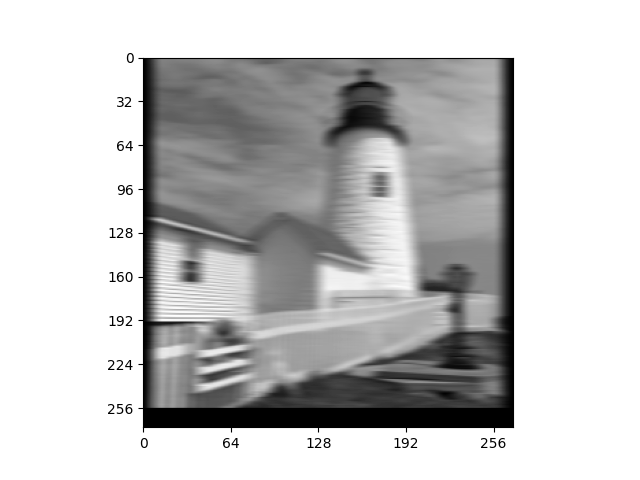

In [4]:
# your code here
Xf = np.empty(shape=[270, 270])
for i in range(len(X)):
    Xf[i] = np.convolve(halfcos(15), X[i])
# fig, ax = plt.subplots()
fig, ax = plt.subplots()
plot_image(Xf, ax=ax)

Trim the filtered image `Xf` to its correct size using `Xf[:, 7:256+7]` and display it:

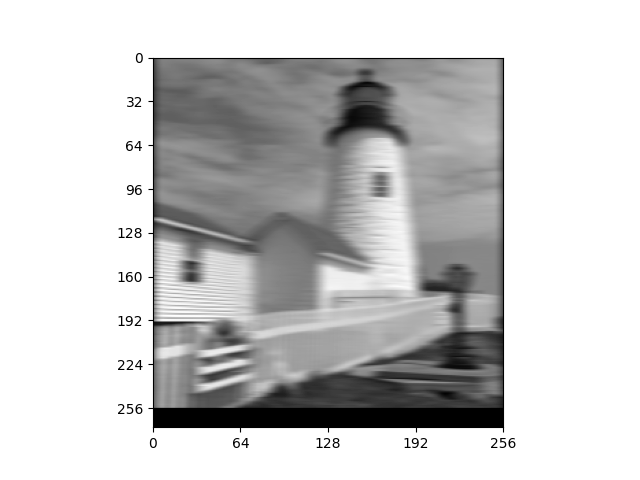

In [5]:
Xf_trim = Xf[:, 7:256+7]
fig, ax = plt.subplots()
plot_image(Xf_trim, ax=ax)

Note that darkening of the sides is still visible, since the lowpass filter
assumes that the intensity is zero outside the image.

Image trimming and convolution of all the image rows can also be achieved using the [`scipy.signal.convolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) function with the `mode='same'` argument. Note we have to turn `h` into a 2d filter by wrapping it in `[]`:
```python
Xf = scipy.signal.convolve(X, [h])
```

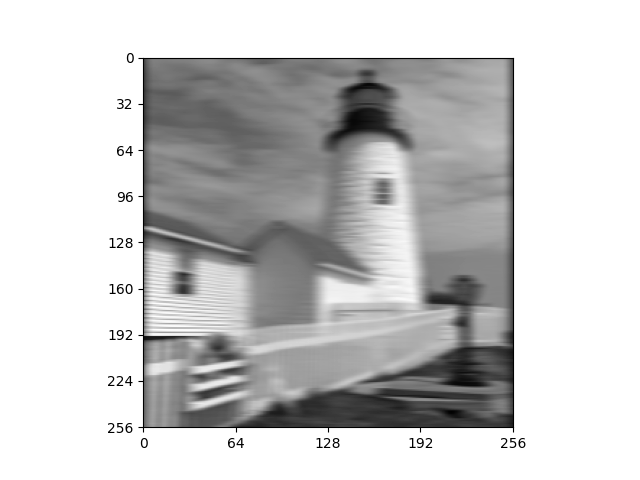

In [6]:
# your code here - use `scipy.signal.convolve` instead of the for loop containing `np.convolve`:


# define a 15-sample halfcosine
h = halfcos(15)
Xf = scipy.signal.convolve(X, [h], mode='same')

fig, ax = plt.subplots()
plot_image(Xf, ax=ax)

Symmetric extension is a technique to minimise edge effects when images of
finite size are filtered.  It assumes that the image is surrounded by a
flat mirror along each edge so it extends into mirror-images (symmetric
extensions) of itself in all directions over an infinite plane.  If the filter
impulse response is symmetrical about its mid point, then the filtered image
will also be symmetrically extended in all directions with the same period as
the original images.  Hence it is only necessary to define the filtered image
over the same area as the original image, for it to be defined over the whole
infinite plane.

Let us consider a one-dimensional example for a 4-point input signal
$a,b,c,d$.  This may be symmetrically extended in one of two ways:

$$
 \ldots d,c,b,\underbrace{a,b,c,d,}_{\text{original}}c,b,a \ldots
\quad \text{or} \quad
 \ldots d,c,b,a,\underbrace{a,b,c,d,}_{\text{original}}d,c,b,a \ldots
$$

The left-hand method, where the end points are not repeated at each boundary, is most
suitable when the signal is to be filtered by a filter of odd length. The other method is most suited to filters of even length.

In Python, a matrix with symmetrically extended rows can be obtained with [`np.pad`](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) using the `reflect` and `symmetric` modes:

***NOTE BY DOING THIS WE ENSURE THE EDGE PIXELS REMAIN UNCHANGED AFTER FILTERING WHICH SEEMS LIKE SOMETHING WE WOULD WANT!***

In [7]:
x = np.array([
    ["a", "b", "c", "d"],
    ["A", "B", "C", "D"]])
print(np.pad(x, [(0, 0), (2, 2)], mode='reflect'))    # for filters of odd length
print()
print(np.pad(x, [(0, 0), (2, 2)], mode='symmetric'))  # for filters of even length

[['c' 'b' 'a' 'b' 'c' 'd' 'c' 'b']
 ['C' 'B' 'A' 'B' 'C' 'D' 'C' 'B']]

[['b' 'a' 'a' 'b' 'c' 'd' 'd' 'c']
 ['B' 'A' 'A' 'B' 'C' 'D' 'D' 'C']]


Here, `[(0, 0), (2, 2)]` reads as _"pad with 0 entries above and below, and 2 entries to the left and right"_.

The function `convse` make use of this to filter
the rows of matrix `X` using the appropriate form of
symmetric extension. The filtering is performed by accumulating shifted
versions of `X` in `Xe`, each weighted by the appropriate element of
`h`. Check that you understand how this function works.

In [8]:
IPython.display.Code(inspect.getsource(convse), language="python")

def convse(X: np.ndarray, h: np.ndarray) -> np.ndarray:
    """
    Filter rows of image X using filter h with symmetric extension of X.

    Parameters:
        X: Image matrix (Usually 256x256)
        h: Filter coefficients
    Returns:
        Y: Row - Filtered image

    PS: Need to apply `convse` twice to filter rows and columns.
    """
    r, c = X.shape
    m = len(h)
    m2 = m // 2
    if m % 2:
        X = np.pad(X, [(0, 0), (m2, m2)], mode='reflect')
    else:
        X = np.pad(X, [(0, 0), (m2, m2)], mode='symmetric')

    Y = np.zeros((r, c))
    # Loop for each term in h. This loop is the convolution.
    for i in range(m):
        Y = Y + h[i] * X[:, i:i+c]
    return Y

Note that this `convse` is actually provided as part of scipy, as [`scipy.ndimage.convolve1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve1d.html), but `convse` is much easier to understand the implementation of.

Use `convse` to filter the rows of your image with the
15-tap half-cosine filter, noting the absence of edge effects.

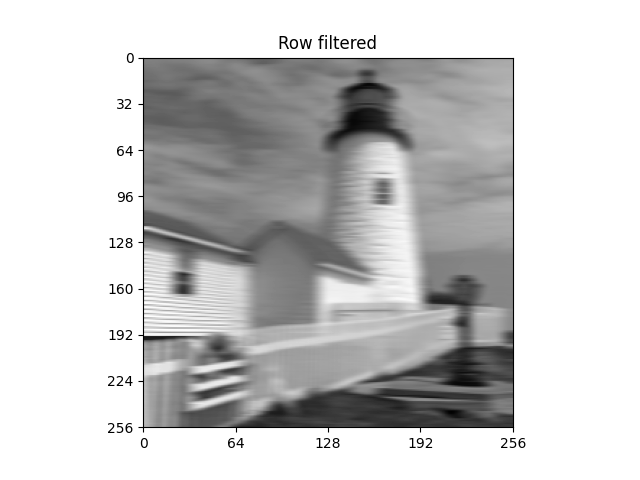

In [9]:
# your code here
h = halfcos(15)
Xf = convse(X, h)
fig, ax = plt.subplots()
ax.set(title='Row filtered')
plot_image(Xf, ax=ax)

Now filter the columns of the _row-filtered_ image by use of the Python transpose operation `.T`.

(Note that unlike the Matlab version of this lab, the function `conv2se` has not been provided)

<div class="alert alert-block alert-danger">

Does it make any difference whether the rows or columns are filtered first? (You should test this accurately by measuring the maximum absolute pixel difference between the row-column and column-row filtered images. Beware of scientific notation, used by Python for very small numbers!)

MAKES NO DIFFERENCE! (see below)
</div>

0.0
Max absolute pixel between the filtered images is: 0.0


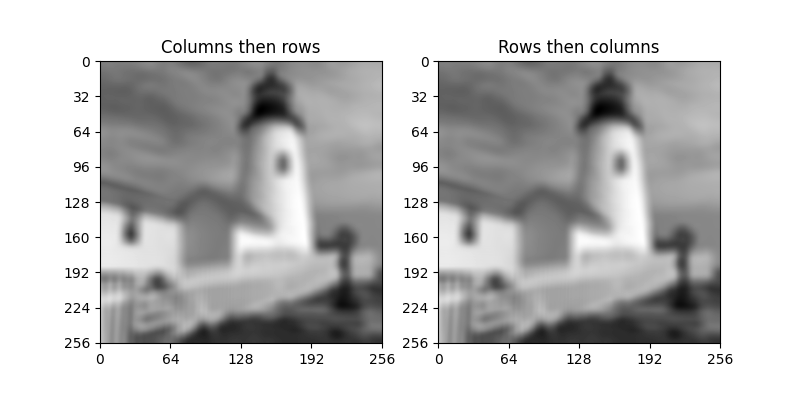

In [10]:
# your code here
h = halfcos(15)
Xf_col = convse(X.T, h)
Xf_col_then_row = convse(Xf.T, h)

Xf_row = convse(X, h)
Xf_row_then_col = convse(Xf.T, h)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # this demonstrates how to plot multiple figures side-by-side
plot_image(Xf_col_then_row.T, ax=axs[0])
axs[0].set(title='Columns then rows')
plot_image(Xf_row_then_col.T, ax=axs[1])
axs[1].set(title='Rows then columns')

max_err = 0.0

for i in range(len(Xf_col_then_row)):
    for j in range(len(Xf_col_then_row[0])):
        err = abs(Xf_col_then_row[i][j] - Xf_row_then_col[i][j])
        if err > max_err:
            max_err = err

# Easier method to show zero error
err = Xf_col_then_row - Xf_col_then_row
print(np.max(err))
    

print(f"Max absolute pixel between the filtered images is: {max_err}")

This process of separate row and column filtering is known as
*separable* 2-D filtering, and is much more efficient than
the more general non-separable 2-D filtering.

It is possible to construct a 2-D _high-pass_ filter by subtracting the 2-D low-pass
result from the original. Note that your 2-D lowpass filter `h` _must_ have a DC gain (sum of all filter coefficients) of unity for this to correctly produce a highpass filter. The
highpass image `Y` now contains negative, as well as positive
pixel values, so it is sensible to display the result using `imshow(Y)` which automatically compensates for this.

It makes sense to call the DC gain the sum of the filter coefficients - imagine how the filter treats the zero frequency (DC) component (i.e. constant values) - each pixel in image will be scaled by sum of filter coefficients! Hence in order to make sure the low-pass components in our image aren't scaled up/down and hence cancel when we subtract we need this gain to be unity!

<div class="alert alert-block alert-danger">

Try generating both low-pass and high-pass versions of `X` using a range of different odd-length half-cosine filters. Comment on the relative effects of these filters

</div>

[Text(0.5, 1.0, 'High-pass X with length 27 filter')]

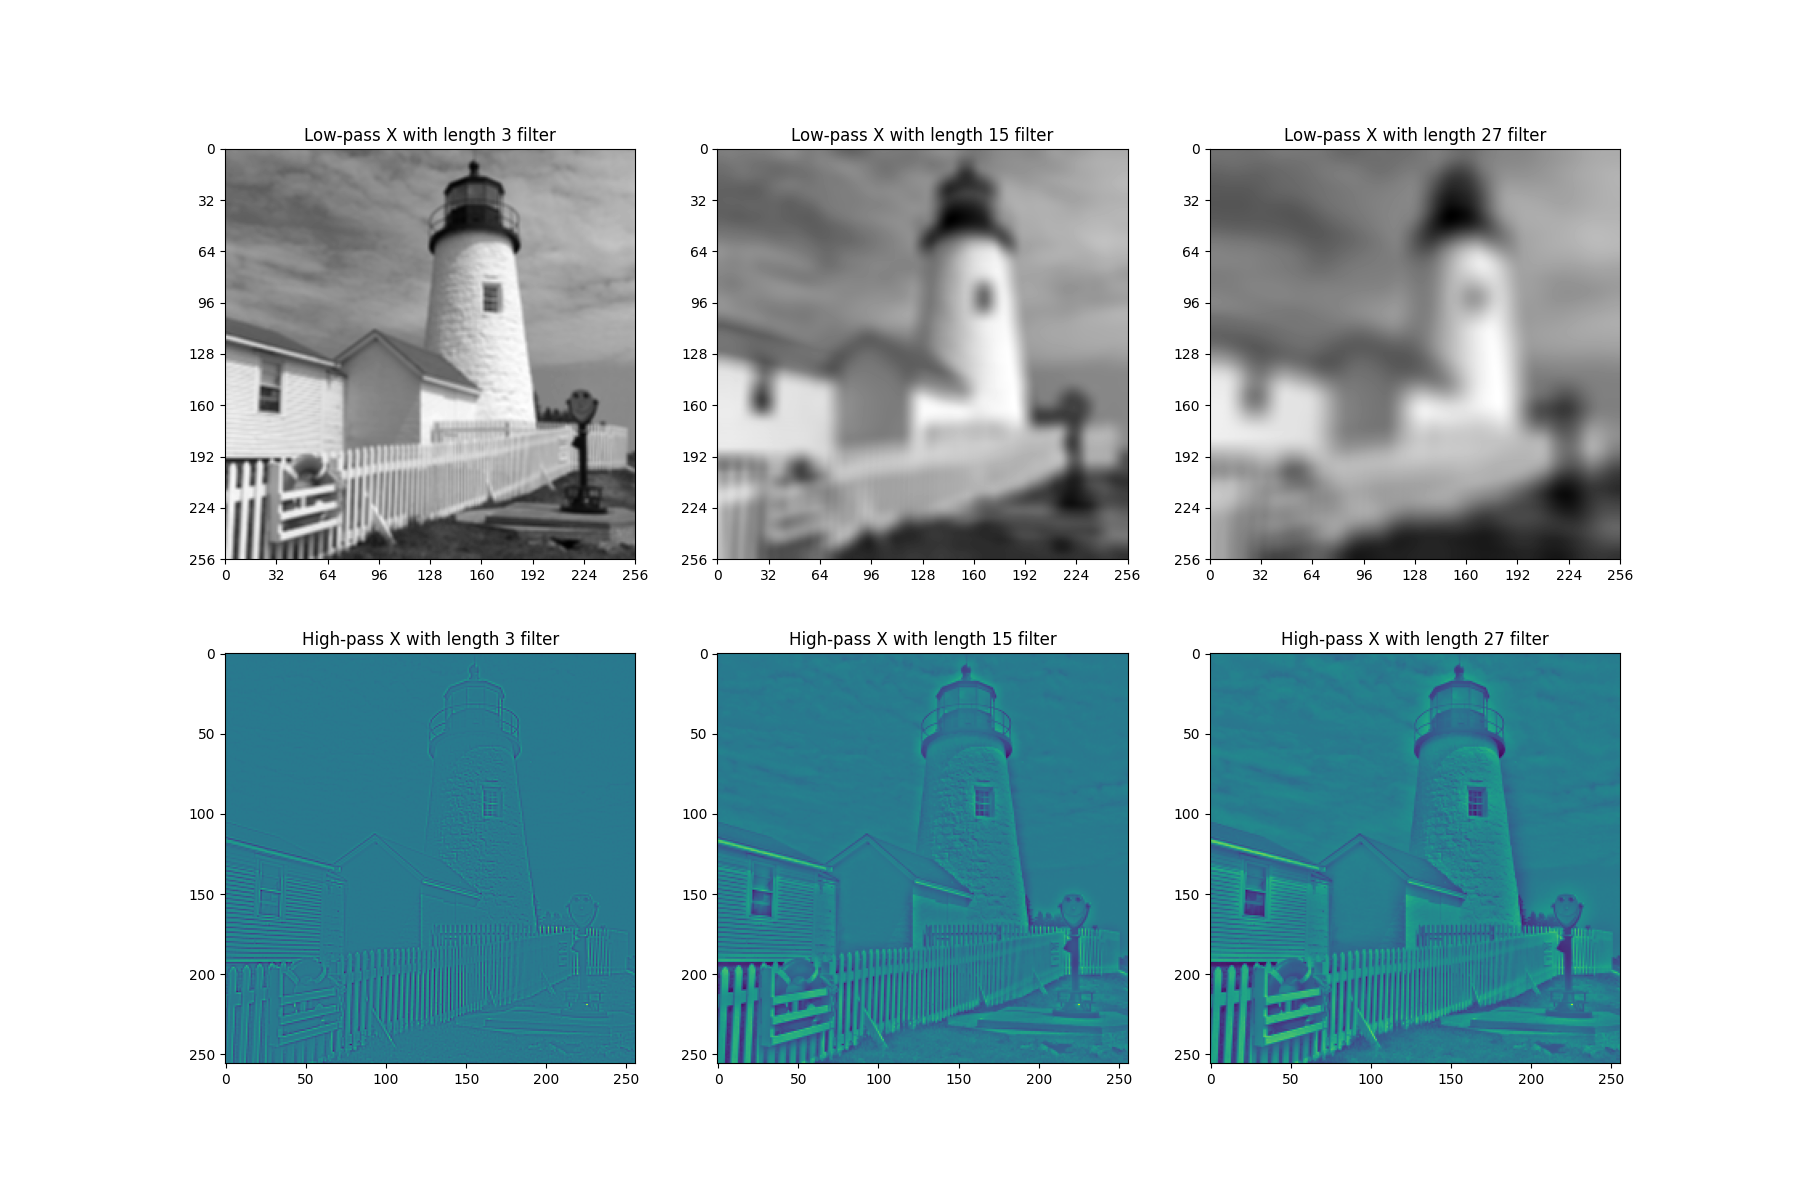

In [11]:
# your code here
h1 = halfcos(15)
Xf1_col = convse(X.T, h1)
Xf1_low = convse(Xf1_col.T, h1)
Xf1_high = X - Xf1_low


h2 = halfcos(3)
Xf2_col = convse(X.T, h2)
Xf2_low = convse(Xf2_col.T, h2)
Xf2_high = X - Xf2_low


h3 = halfcos(27)
Xf3_col = convse(X.T, h3)
Xf3_low = convse(Xf3_col.T, h3)
Xf3_high = X - Xf3_low

fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # this demonstrates how to plot multiple figures side-by-side

plot_image(Xf1_low, ax=axs[0, 1])
axs[0, 1].set(title='Low-pass X with length 15 filter')
axs[1, 1].imshow(Xf1_high)
axs[1, 1].set(title='High-pass X with length 15 filter')

plot_image(Xf2_low, ax=axs[0, 0])
axs[0, 0].set(title='Low-pass X with length 3 filter')
axs[1, 0].imshow(Xf2_high)
axs[1, 0].set(title='High-pass X with length 3 filter')

plot_image(Xf3_low, ax=axs[0, 2])
axs[0, 2].set(title='Low-pass X with length 27 filter')
axs[1, 2].imshow(Xf3_high)
axs[1, 2].set(title='High-pass X with length 27 filter')

One way to assess sets of filtered images like these is to contrast the *energy* content. In this context, the energy `E` of an image `X` is given by the sum of the squares of the individual pixel values:
```python
E = np.sum(X**2.0)
```
Remember that $a^b$ is spelt `a**b` in Python, not `a^b`. We make sure to use `2.0` and not `2`, as `np.array(16, dtype=np.uint8)**2` overflows the bounds of `uint8` and gives `0`, while `2.0` tells numpy to use at least `float64` instead.

<div class="alert alert-block alert-danger">
What do you observe about the energy of the highpass images, compared with that of the lowpass images?
</div>
Energy of high-pass is much lower (as we would expect of most real-world images!)
If use half-cosine filter with larger length, high-pass image becomes high energy and low-pass image lower energy - this is clearly visible in the images above where the low length filter barely changes the original image in low-pass and the high-pass image has very few recognisable features. The high-pass filter with largest length clearly has the most recognisable features - this checks out with the higher energy.

In [12]:
E1_low = np.sum(Xf1_low**2.0)
E1_high = np.sum(Xf1_high**2.0)

E2_low = np.sum(Xf2_low**2.0)
E2_high = np.sum(Xf2_high**2.0)

E3_low = np.sum(Xf3_low**2.0)
E3_high = np.sum(Xf3_high**2.0)

print("Energy of low-pass X with length 3 filter:", E1_low)
print("Energy of high-pass X with length 3 filter:", E1_high)

print("Energy of low-pass X with length 9 filter:", E2_low)
print("Energy of high-pass X with length 9 filter:", E2_high)

print("Energy of low-pass X with length 27 filter:", E3_low)
print("Energy of high-pass X with length 27 filter:", E3_high)

Energy of low-pass X with length 3 filter: 1255989103.0366883
Energy of high-pass X with length 3 filter: 47950210.247288465
Energy of low-pass X with length 9 filter: 1290414313.134402
Energy of high-pass X with length 9 filter: 15467995.295631265
Energy of low-pass X with length 27 filter: 1240210309.7865427
Energy of high-pass X with length 27 filter: 59556051.28966357


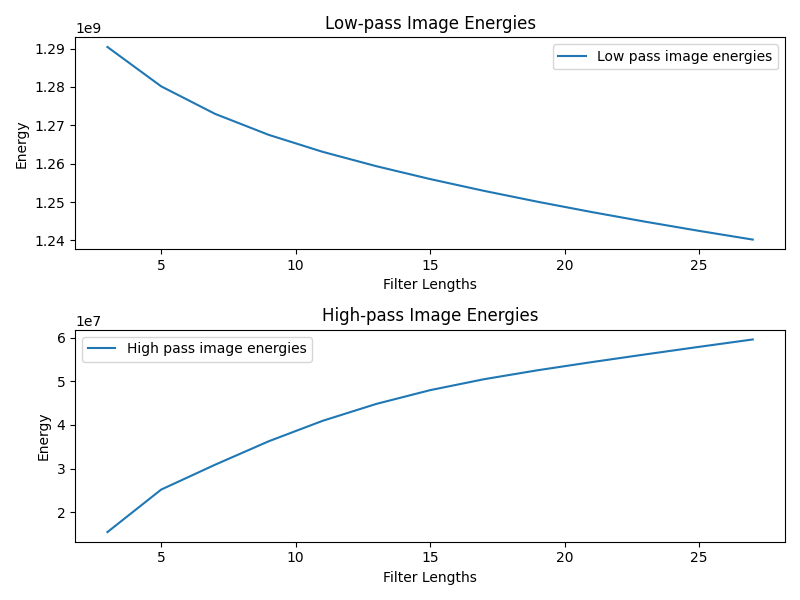

In [13]:
energies_low = []
energies_high = []

filter_lengths = range(3, 29, 2)

for i in filter_lengths:
    h = halfcos(i)
    Xf_col = convse(X.T, h)
    Xf_low = convse(Xf_col.T, h)
    Xf_high = X - Xf_low

    E_low = np.sum(Xf_low**2.0)
    E_high = np.sum(Xf_high**2.0)

    energies_low.append(E_low)
    energies_high.append(E_high)


fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].plot(filter_lengths, energies_low, label='Low pass image energies')
ax[0].set_xlabel('Filter Lengths')
ax[0].set_ylabel('Energy')
ax[0].set_title('Low-pass Image Energies')
ax[0].legend()

ax[1].plot(filter_lengths, energies_high, label='High pass image energies')
ax[1].set_xlabel('Filter Lengths')
ax[1].set_ylabel('Energy')
ax[1].set_title('High-pass Image Energies')
ax[1].legend()

plt.tight_layout()
plt.show()